# <h1 align="center"><font color = #0081be>Lighthouse | Cientista de Dados | Indicium 🌎🚀</font></h1>

## <a><font color = #0081be>**Objetivos**</font></a>
A empresa Adventure Works (AW) é uma indústria de bicicletas com mais de 500 produtos distintos, 20.000 clientes e 31.000 pedidos. Nesse desafio, será realizada uma previsão de demanda, a fim, de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima.

> <a><font color = #0081be>**1.**</font></a> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

>  <a><font color = #0081be>**2.**</font></a> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.
   
> <a><font color = #0081be>**3.**</font></a> Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?
   
> <a><font color = #0081be>**4.**</font></a> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?

## Instalações e importações das bibliotecas

In [1]:
!pip install statsforecast
!pip install hierarchicalforecast

In [2]:
!pip install unidecode

In [3]:
!pip install google-cloud-bigquery

In [4]:
!pip install pandas-gbq

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from unidecode import unidecode
import xgboost as xgb

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.formula.api import ols

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, HoltWinters

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder

from google.cloud import bigquery

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Carregamento dos Dados do BigQuery

In [6]:
from google.colab import auth
auth.authenticate_user()

In [7]:
client = bigquery.Client()

project_id = 'projectaw'
dataset_id = 'dev_andressa_marts'
table_id = 'fct_sales2'

table_ref = client.get_table(f"{project_id}.{dataset_id}.{table_id}")

In [8]:
df = pd.read_gbq(f"select * from `{project_id}.{dataset_id}.{table_id}`", project_id=project_id)

## Informações sobre o DataFrame

In [9]:
df.head()

,fct_sales_sk,sales_order_id,customer_fk,location_fk,credit_card_fk,reason_fk,product_fk,order_date,ship_date,status_sales,...,Price,Manufacturer,Quality,Promotion,Review,Other,Television,product_name,product_subcategory_name,product_category_name
0,009387d962ff822943b216514cc3701a,48707,af5b61bece62a3ec55e911f3ce5e7857,0390aff9c68eeb7b64fbebe21c878de3,2ff7b03aaa6645dd2263c569d0ff7f54,None,06997f04a7db92466a2baa6ebc8b872d,2012-11-27,2012-12-04,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Road-650 Red, 44",Bicicletas de estrada,Bicicletas
1,00bb86fad1c914c6af41ba50aefde263,51721,d8591042aaf8c8d8b53b7e43085a0587,a0160709701140704575d499c997b6ca,816a6db41f0e44644bc65808b6db5ca4,None,352407221afb776e3143e8a1a0577885,2013-06-30,2013-07-07,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Bike Wash - Dissolver,Limpadores,Acessórios
2,013170e848dcf84308561309291e7ed6,50663,c928d38c5e85028940fbf707e6d20c7d,860320be12a1c050cd7731794e231bd3,41f1f19176d383480afa65d325c06ed0,None,3d8e28caf901313a554cebc7d32e67e5,2013-04-30,2013-05-07,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Cable Lock,Fechaduras,Acessórios
3,0133748cac6a11aa0620e6f3a595091e,46604,f0e37e9e9b28f94f89e67d28df74c2b4,54a367d629152b720749e187b3eaa11b,3a1051d7bc1590ef30337746a52506b9,None,e49b8b4053df9505e1f48c3a701c0682,2012-05-30,2012-06-06,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"HL Mountain Frame - Silver, 38",Quadros de montanha,Componentes
4,0176e50ceab7060d9c536085eac29a21,43676,b3d299cba3d27f7e8bb7818c4b421f9d,ccb0989662211f61edae2e26d58ea92f,409072cb60e202d2797a91e395909240,None,1ecfb463472ec9115b10c292ef8bc986,2011-05-31,2011-06-07,Enviado,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Mountain Bike Socks, M",Meias,Roupas


In [10]:
df.shape

(121317, 44)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fct_sales_sk              121317 non-null  object 
 1   sales_order_id            121317 non-null  Int64  
 2   customer_fk               121317 non-null  object 
 3   location_fk               121317 non-null  object 
 4   credit_card_fk            118744 non-null  object 
 5   reason_fk                 53969 non-null   object 
 6   product_fk                121317 non-null  object 
 7   order_date                121317 non-null  dbdate 
 8   ship_date                 121317 non-null  dbdate 
 9   status_sales              121317 non-null  object 
 10  onlineorderflag           121317 non-null  boolean
 11  subtotal                  121317 non-null  float64
 12  taxamt                    121317 non-null  float64
 13  freight                   121317 non-null  f

**Informações estatísticas para variáveis numéricas**

In [12]:
df.describe()

,sales_order_id,subtotal,taxamt,freight,totaldue,orderqty,unitprice,unitpricediscount,amount_paid_product,standardcost,...,safetystocklevel,reorderpoint,daystomanufacture,Price,Manufacturer,Quality,Promotion,Review,Other,Television
count,121317.0,121317.000000,121317.000000,121317.000000,121317.000000,121317.0,121317.000000,121317.000000,121317.000000,121317.000000,...,121317.0,121317.0,121317.0,53969.0,53969.0,53969.0,53969.0,53969.0,53969.0,53969.0
mean,57827.363782,21402.362873,2075.630531,648.634554,24126.627959,2.26608,465.093496,0.002826,909.780544,373.686117,...,169.938162,127.453622,1.486675,0.884452,0.033686,0.028739,0.13693,0.030388,0.067687,0.013526
std,9009.147902,28509.182428,2795.708770,873.658983,32173.502712,2.491323,751.885081,0.024811,1705.221114,554.114063,...,205.181248,153.885936,1.805957,0.319685,0.180421,0.167073,0.343777,0.171654,0.25121,0.115514
min,43659.0,1.374000,0.109900,0.034400,1.518300,1.0,1.328200,0.000000,1.374000,0.856500,...,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,49884.0,564.480000,45.237600,14.136800,623.750400,1.0,21.490000,0.000000,24.990000,9.159300,...,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,57029.0,2518.980000,205.193600,64.123000,2785.517200,1.0,49.990000,0.000000,134.982000,38.492300,...,100.0,75.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,65490.0,37202.781200,3598.309200,1124.471600,41890.970300,3.0,602.346000,0.000000,1120.490000,486.706600,...,500.0,375.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
max,75123.0,163930.394300,17948.518600,5608.912100,187487.825000,44.0,3578.270000,0.400000,30990.310000,2171.294200,...,500.0,375.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Informações estatísticas para as variáveis categóricas**

In [13]:
df.describe(include='object').T

,count,unique,top,freq
fct_sales_sk,121317,121317,009387d962ff822943b216514cc3701a,1
customer_fk,121317,19119,ff23707fd0625ccdfb4f42ddbaf1a649,530
location_fk,121317,19119,15de21c670ae7c3f6f3f1f37029303c9,530
credit_card_fk,118744,18384,b31f0c758bb498b5d56b5fea80f313a7,530
reason_fk,53969,23012,f5efd30f66df1357b7f22fe4bc036951,8
product_fk,121317,266,22fb0cee7e1f3bde58293de743871417,4688
status_sales,121317,1,Enviado,121317
customer_person_type,121317,2,Contato da loja,60919
name_store,60919,633,Vigorous Exercise Company,530
city,121317,535,Toronto,3498


## Tratamento de Valores Nulos

In [14]:
df.isnull().sum()

fct_sales_sk                    0
sales_order_id                  0
customer_fk                     0
location_fk                     0
credit_card_fk               2573
reason_fk                   67348
product_fk                      0
order_date                      0
ship_date                       0
status_sales                    0
onlineorderflag                 0
subtotal                        0
taxamt                          0
freight                         0
totaldue                        0
orderqty                        0
unitprice                       0
unitpricediscount               0
amount_paid_product             0
standardcost                    0
listprice                       0
makeflag                        0
finishedgoodsflag               0
safetystocklevel                0
reorderpoint                    0
daystomanufacture               0
customer_person_type            0
name_store                  60398
city                            0
postalcode    

**Excluindo as *features* dos identificadores únicos**

In [15]:
df = df.drop('fct_sales_sk', axis=1)
df = df.drop('sales_order_id', axis=1)
df = df.drop('customer_fk', axis=1)
df = df.drop('location_fk', axis=1)
df = df.drop('credit_card_fk', axis=1)
df = df.drop('reason_fk', axis=1)
df = df.drop('product_fk', axis=1)
df = df.drop('status_sales', axis=1)
df = df.drop('cardtype', axis=1)
df = df.drop('ship_date', axis=1)

**Para o tratamento dos dados Missing (NaN) iremos considerar que os valores ausentes das seguintes *features* são representados por 0.**

In [16]:
df['Price'] = df['Price'].replace(np.nan, 0)
df['Manufacturer'] = df['Manufacturer'].replace(np.nan, 0)
df['Quality'] = df['Quality'].replace(np.nan, 0)
df['Promotion'] = df['Promotion'].replace(np.nan, 0)
df['Review'] = df['Review'].replace(np.nan, 0)
df['Other'] = df['Other'].replace(np.nan, 0)
df['Television'] = df['Television'].replace(np.nan, 0)

**Os valores ausentes para a loja são representados por uma compra de um cliente individual.**

In [17]:
df['name_store'] = df['name_store'].replace(np.nan, 'Cliente individual')

## Pré-Processamento dos Dados

In [18]:
df['order_date'] = pd.to_datetime(df['order_date'])
df["month"] = pd.to_datetime(df["order_date"]).dt.to_period('M').dt.to_timestamp()

In [19]:
df['name_store'] = df['name_store'].str.replace('/', ' ')
df['product_name'] = df['product_name'].str.replace('/', ' ')
df['product_name'] = df['product_name'].str.replace('-', ' ')
df['country_region_name'] = df['country_region_name'].apply(lambda x: unidecode(str(x)))
df['product_subcategory_name'] = df['product_subcategory_name'].apply(lambda x: unidecode(str(x)))

## Análise Exploratória de Dados (EDA)

In [20]:
def plot_annotate(ax, title):
    """ Adicionar anotações nos gráficos.

    Args:
        ax: Objeto do tipo Axes do Matplotlib
        title (string): Título do gráfico
    Returns:
        None
    """

    for rect in ax.patches:
        ax.annotate(rect.get_height(),
                (rect.get_x() + rect.get_width()/2, rect.get_height()),
                ha='center', va='baseline', fontsize=8, color=neutral_500,
                xytext=(0, 1), textcoords="offset points")
    ax.set_title(title)


# Cores
cerulean="#0081be"
web_orange="#f7a600"
port_gore="#1a2144"
chambray="#333b8f"
sandal="#9c8b64"
curious_blue="#13a0db"
cornflower="#88bce7"
abbey="#1b1d1e"
neutral_500="#878b97"

In [21]:
monthly_sales = (
    df
    .groupby("month")["orderqty"].sum()
    .reset_index()
)

monthly_sales.head()

,month,orderqty
0,2011-05-01,825
1,2011-06-01,141
2,2011-07-01,2209
3,2011-08-01,2904
4,2011-09-01,157


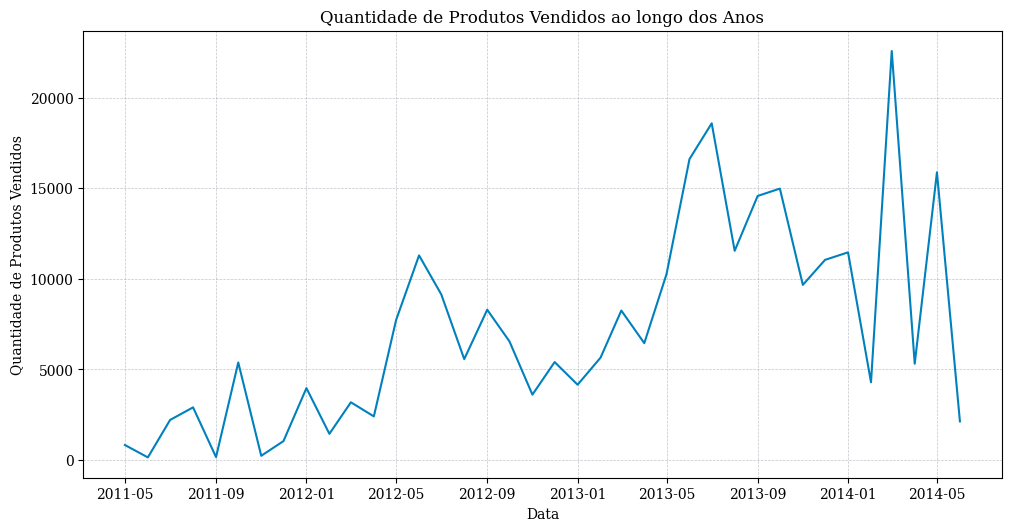

In [22]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly_sales.sort_values('month', ascending=True)

xs = df_sorted['month']
ys = df_sorted['orderqty']

plt.plot(xs, ys, color=cerulean)

plt.title('Quantidade de Produtos Vendidos ao longo dos Anos')
plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos Vendidos')

plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

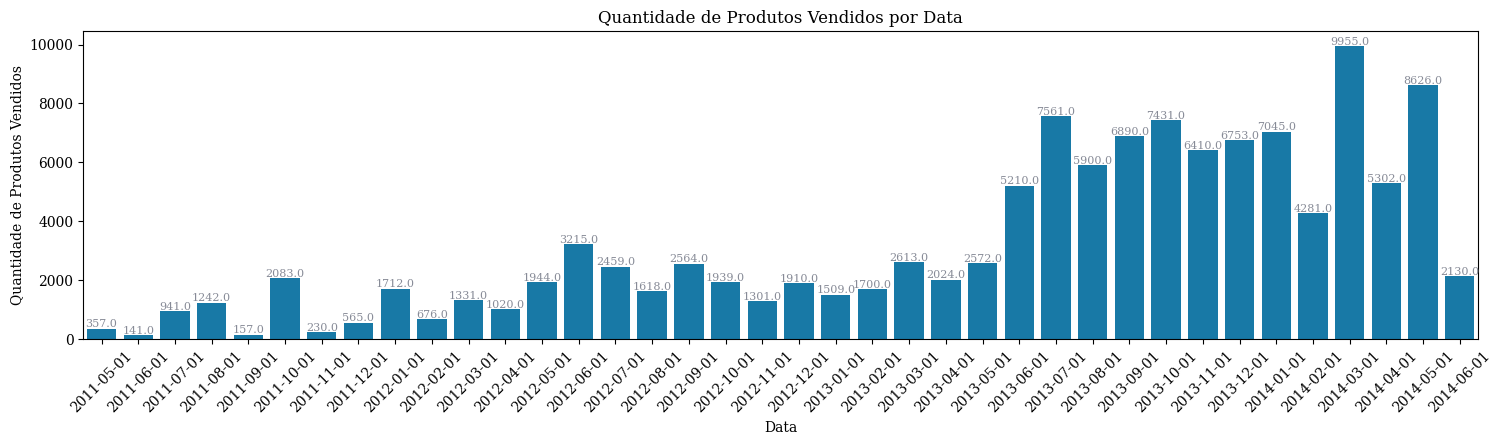

In [23]:
df['month'] = pd.to_datetime(df['month'])
df_sorted = df.sort_values('month')

fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='month', data=df_sorted, color=cerulean)
plt.xticks(rotation=45)

plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos Vendidos')
plot_annotate(ax, 'Quantidade de Produtos Vendidos por Data')
plt.show()

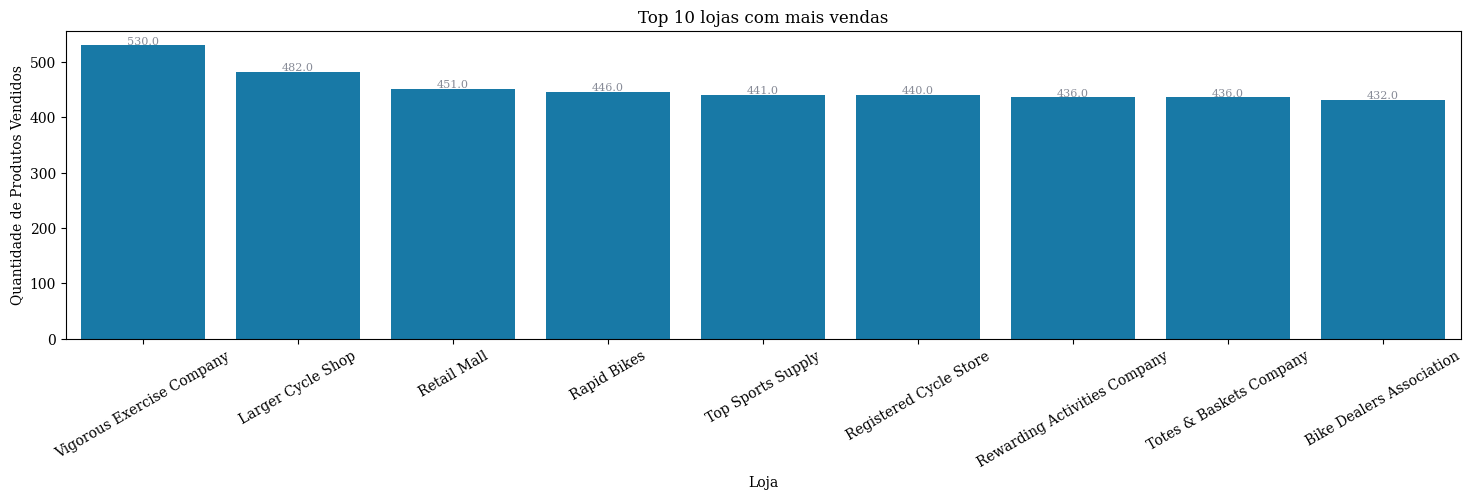

In [24]:
top_stores = df['name_store'].value_counts().nlargest(10).index
top_stores = top_stores[1:]
df_top_stores = df[df['name_store'].isin(top_stores)]
df_top_stores['name_store'] = pd.Categorical(df_top_stores['name_store'], categories=top_stores, ordered=True)


fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='name_store', data=df_top_stores, color=cerulean)
plt.xticks(rotation=30)
plot_annotate(ax, 'Top 10 lojas com mais vendas')
plt.xlabel('Loja')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()


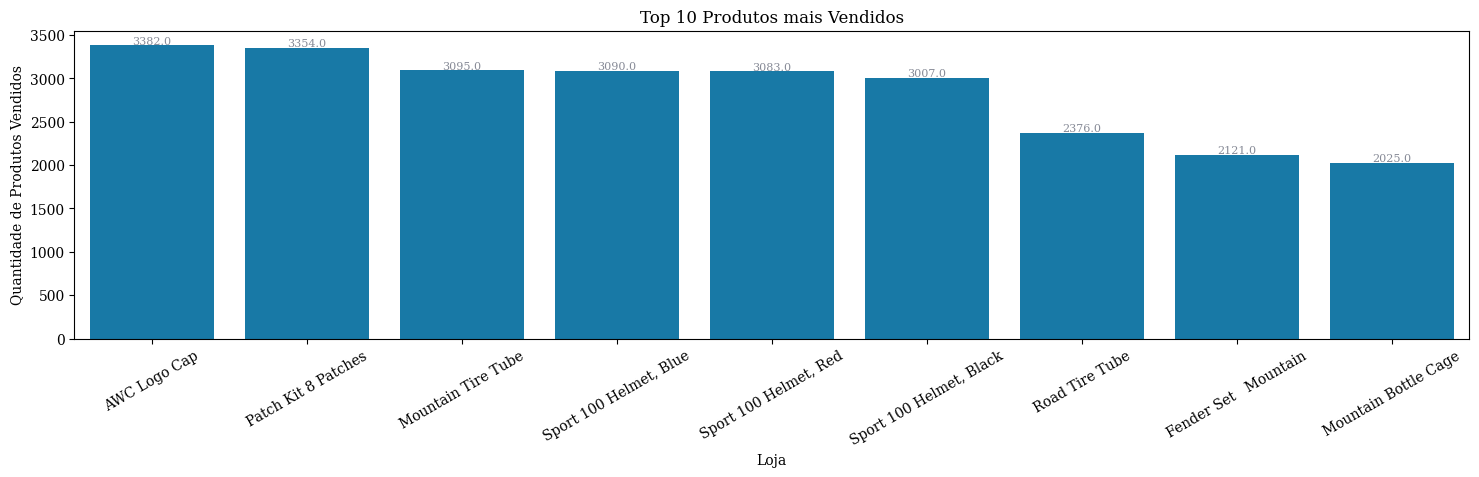

In [25]:
top_stores = df['product_name'].value_counts().nlargest(10).index
top_stores = top_stores[1:]
df_top_stores = df[df['product_name'].isin(top_stores)]
df_top_stores['product_name'] = pd.Categorical(df_top_stores['product_name'], categories=top_stores, ordered=True)


fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='product_name', data=df_top_stores, color=cerulean)
plt.xticks(rotation=30)
plot_annotate(ax, 'Top 10 Produtos mais Vendidos')
plt.xlabel('Loja')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()


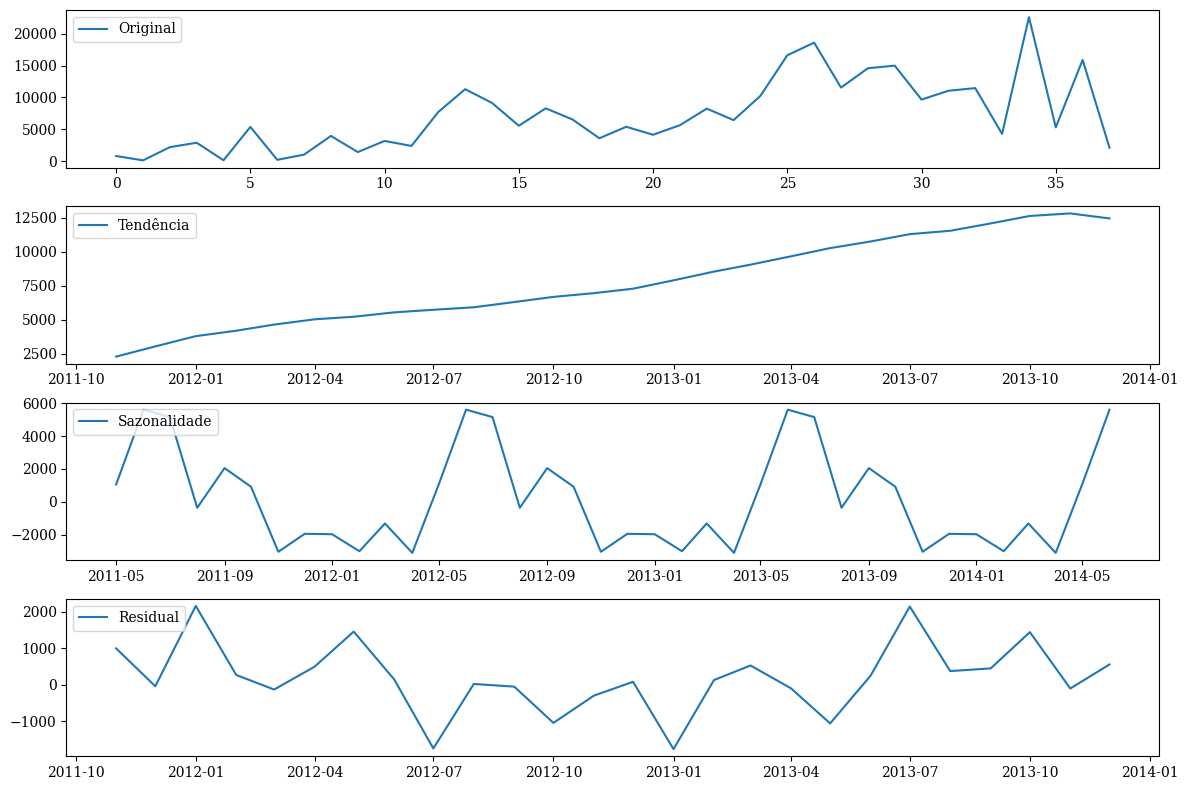

In [26]:
result = seasonal_decompose(monthly_sales.set_index('month')["orderqty"], model='additive', period=12)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['orderqty'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Tendência')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Sazonalidade')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

## Séries Hierárquicas






<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>1.</b></font> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.</h4>

  * Para analisar a distribuição de produtos, foi empregado o modelo ***AutoARIMA*** para prever a demanda dos próximos três meses para cada produto em cada região e loja.
  * Além disso, foi investigado a sazonalidade específica do produto  "AWC Logo Cap".
</blockquote>



In [27]:
hts = (
    df
    .groupby([
        'month','product_name', 'country_region_name', 'name_store'])["orderqty"].sum()
    .reset_index()
)

hts.head()

,month,product_name,country_region_name,name_store,orderqty
0,2011-05-01,AWC Logo Cap,Canada,Original Bicycle Supply Company,4
1,2011-05-01,AWC Logo Cap,Canada,Retail Mall,4
2,2011-05-01,AWC Logo Cap,Canada,Superb Sales and Repair,5
3,2011-05-01,AWC Logo Cap,Estados Unidos,Area Bike Accessories,3
4,2011-05-01,AWC Logo Cap,Estados Unidos,Better Bike Shop,2


In [28]:
hierarchies = [
    ['product_name'],
    ['country_region_name'],
    ['product_name', 'country_region_name'],
    ['product_name', 'country_region_name', 'name_store'],
]

In [29]:
hts = hts.rename(columns={"month": "ds", "orderqty": "y"})

In [30]:
Y_df, S_df, tags = aggregate(hts, hierarchies)
Y_df = Y_df.reset_index()
Y_df

,unique_id,ds,y
0,AWC Logo Cap,2011-05-01,40
1,AWC Logo Cap,2011-07-01,103
2,AWC Logo Cap,2011-08-01,137
3,AWC Logo Cap,2011-10-01,240
4,AWC Logo Cap,2011-12-01,25
...,...,...,...
89429,"Women's Tights, S/Reino Unido/Prosperous Tours",2012-08-01,3
89430,"Women's Tights, S/Reino Unido/Prosperous Tours",2012-11-01,7
89431,"Women's Tights, S/Reino Unido/Prosperous Tours",2013-02-01,5
89432,"Women's Tights, S/Reino Unido/Uttermost Bike Shop",2012-09-01,3


**Vamos selecionar apenas os produtos que venderam mais de 5 vezes em cada loja / país.**

In [31]:
contagem = Y_df['unique_id'].value_counts()
Y_df = Y_df[Y_df['unique_id'].isin(contagem[contagem > 5].index)]

**Divisão dos dados em treinamento e teste**

- Foram selecionados os últimos 3 meses para teste

In [32]:
test_agg = Y_df.groupby('unique_id').tail(3)
train_agg = Y_df.drop(test_agg.index)

### Treinamento do modelo

In [33]:
fcst = StatsForecast(
    df=train_agg,
    models=[AutoARIMA(season_length=12), Naive()],
    freq='MS',
    n_jobs=-1
  )

In [34]:
Y_hat_df = fcst.forecast(h=3)

In [35]:
xmat = pd.merge(left=test_agg.set_index('unique_id').reset_index(), right=Y_hat_df.reset_index(), on=['unique_id', 'ds'])
xmat2 = xmat.copy()

**Previsão sobre a demanda dos próximos 3 meses de cada produto/país/loja**

In [36]:
xmat['ds'] = pd.to_datetime(xmat['ds'])
xmat_filtrado = xmat[xmat['ds'] >= '2014-03-01']
xmat_filtrado = xmat_filtrado.sort_values(by='ds', ascending=True)

xmat_filtrado.columns = ['Produtos', 'Data', 'Real', 'Previsão', 'Naive']

xmat_filtrado.head(20)

,Produtos,Data,Real,Previsão,Naive
2743,"Road 750 Black, 58/Franca",2014-03-01,5,2.135414,4.0
3054,"Touring 2000 Blue, 50/Alemanha",2014-03-01,1,0.000000,6.0
4820,"Mountain 500 Black, 44/Australia/Cliente indiv...",2014-03-01,2,0.864978,1.0
4817,"Mountain 500 Black, 42/Estados Unidos/Cliente ...",2014-03-01,2,1.570481,2.0
3056,"Touring 2000 Blue, 50/Australia",2014-03-01,5,0.000000,2.0
4814,"Mountain 500 Black, 42/Alemanha/Cliente indivi...",2014-03-01,1,1.000000,1.0
4813,"Mountain 500 Black, 40/Estados Unidos/Cliente ...",2014-03-01,2,4.000000,4.0
4809,"Mountain 400 W Silver, 46/Reino Unido/Cliente ...",2014-03-01,4,0.596017,1.0
4805,"Mountain 400 W Silver, 46/Estados Unidos/Clien...",2014-03-01,7,5.000000,5.0
3059,"Touring 2000 Blue, 50/Canada",2014-03-01,3,0.820521,1.0


### Métricas

**Métricas MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio) - AutoArima**

In [37]:
def my_rmse(x,y):
    return np.round( np.sqrt(mse(x.values,y.values)), 2)

def my_mse(x, y):
    return np.round(mse(x.values, y.values), 2)

def my_mae(x, y):
    return np.round(np.nanmean(abs(x.values -  y.values)), 2)

def creating_results(p_rec_):
  results = []
  for k in tags.keys():
      k_rmse = my_rmse(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])
      k_mse = my_mse(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])
      k_mae = my_mae(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])

      results.append({'Category': k, 'RMSE': k_rmse, 'MSE': k_mse, 'MAE': k_mae})
      results_df = pd.DataFrame(results)

  return results_df

In [38]:
xmat2 = xmat.copy()

In [39]:
xmat2.columns = ['unique_id', 'ds', 'y', 'pred', 'naive']
result_xmat2 = creating_results(xmat2)
result_xmat2.head()

,Category,RMSE,MSE,MAE
0,product_name,91.96,8456.91,53.84
1,country_region_name,2791.79,7794114.31,1619.19
2,product_name/country_region_name,24.89,619.71,12.51
3,product_name/country_region_name/name_store,5.68,32.22,3.57


In [40]:
k_rmse = my_rmse(xmat2['y'], xmat2['pred'])
k_mse = my_mse(xmat2['y'], xmat2['pred'])
k_mae = my_mae(xmat2['y'], xmat2['pred'])

results_arima = {'RMSE': [k_rmse], 'MSE': [k_mse], 'MAE': [k_mae]}
results_df_arima = pd.DataFrame(results_arima)
results_df_arima

,RMSE,MSE,MAE
0,148.43,22030.77,16.06


### Sazonalidade

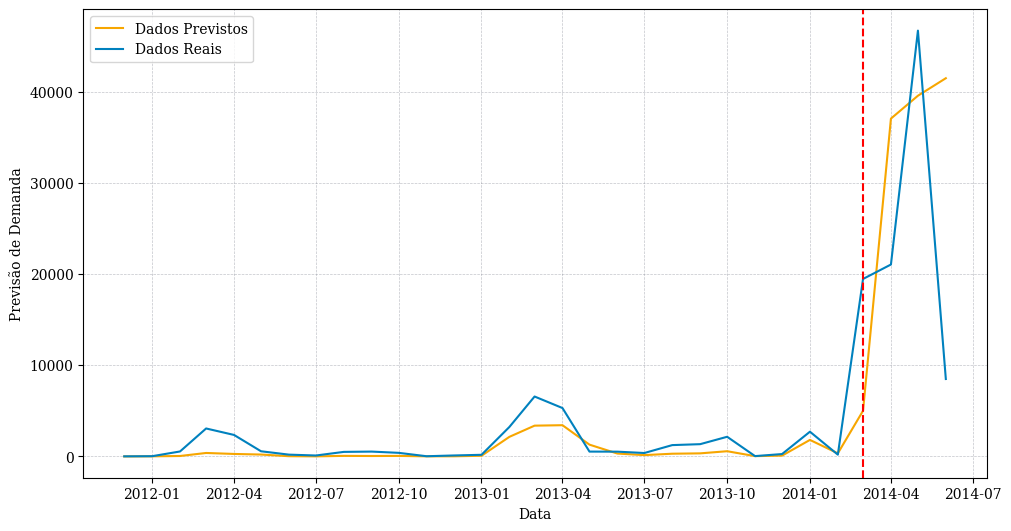

In [41]:
monthly_sales_pred = (
    xmat2
    .groupby("ds")["pred"].sum()
    .reset_index()
)

monthly_sales_y = (
    xmat2
    .groupby("ds")["y"].sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Dados Previstos
df_sorted_pred = monthly_sales_pred.sort_values('ds', ascending=True)
xs_pred = df_sorted_pred['ds']
ys_pred = df_sorted_pred['pred']
plt.plot(xs_pred, ys_pred, color=web_orange, label='Dados Previstos')

# Dados Reais
df_sorted_real = monthly_sales_y.sort_values('ds', ascending=True)
xs_real = df_sorted_real['ds']
ys_real = df_sorted_real['y']
plt.plot(xs_real, ys_real, color=cerulean, label='Dados Reais')

# plt.axvline(x='2014-03-01', color='red', linestyle='--')
date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

**Analisando as vendas do produto 'AWC Logo Cap'**

In [42]:
Y_hat_df_filtered = xmat2[xmat2['unique_id'].str.contains("AWC Logo Cap")]
Y_hat_df_filtered

,unique_id,ds,y,pred,naive
0,AWC Logo Cap,2014-04-01,193,361.524475,663.0
1,AWC Logo Cap,2014-05-01,456,589.481689,663.0
2,AWC Logo Cap,2014-06-01,93,700.828186,663.0
608,AWC Logo Cap/Alemanha,2014-04-01,29,42.662823,81.0
609,AWC Logo Cap/Alemanha,2014-05-01,43,42.662819,81.0
...,...,...,...,...,...
3451,AWC Logo Cap/Reino Unido/Cliente individual,2014-05-01,36,27.593775,30.0
3452,AWC Logo Cap/Reino Unido/Cliente individual,2014-06-01,8,26.464035,30.0
3453,AWC Logo Cap/Reino Unido/Commerce Bicycle Spec...,2013-09-01,4,0.000000,11.0
3454,AWC Logo Cap/Reino Unido/Prosperous Tours,2013-08-01,12,0.000000,12.0


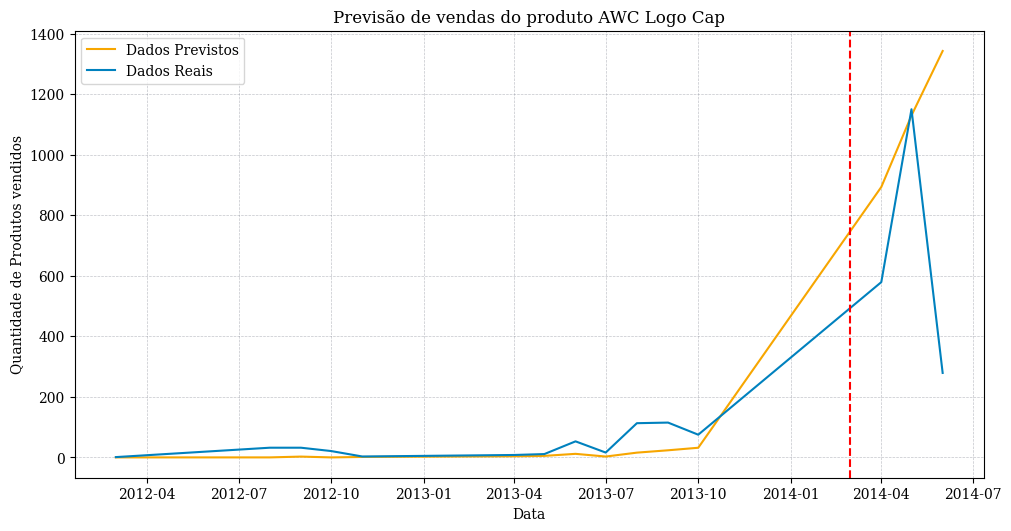

In [43]:
monthly_sales_pred = (
    Y_hat_df_filtered
    .groupby("ds")["pred"].sum()
    .reset_index()
)

monthly_sales_y = (
    Y_hat_df_filtered
    .groupby("ds")["y"].sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

df_sorted_pred = monthly_sales_pred.sort_values('ds', ascending=True)
df_sorted_y = monthly_sales_y.sort_values('ds', ascending=True)

xs_pred = df_sorted_pred['ds']
ys_pred = df_sorted_pred['pred']

xs_y = df_sorted_y['ds']
ys_y = df_sorted_y['y']

plt.plot(xs_pred, ys_pred, color=web_orange, label='Dados Previstos')
plt.plot(xs_y, ys_y, color=cerulean, label='Dados Reais')

date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.title('Previsão de vendas do produto AWC Logo Cap')
plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos vendidos')

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

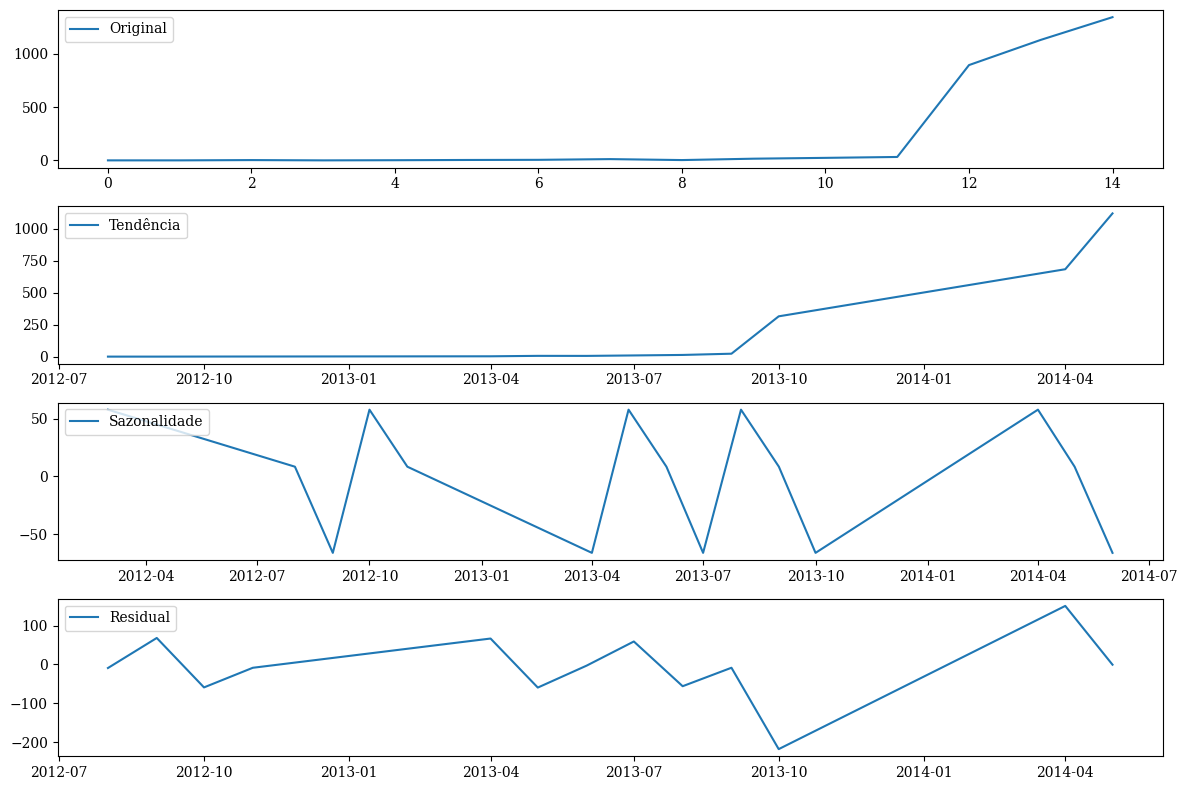

In [44]:
monthly_sales = (
    Y_hat_df_filtered
    .groupby("ds")["pred"].sum()
    .reset_index()
)

result = seasonal_decompose(monthly_sales.set_index('ds')["pred"], model='additive', period=3)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):

    # Plot the original time series, trend, seasonality, and residual
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['pred'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Tendência')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Sazonalidade')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Durante a análise, foram abalisadas as métricas de desempenho, incluindo RMSE, MSE e MSA. Além disso, foi identificada a sazonalidade nos padrões de venda do produto 'AWC Logo Cap'.</p>
</blockquote>

## Regressão com XGBoost Regressor

<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>2.</b></font> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.</h4>

  * Será empregado o modelo ***XGBoost Regressor*** e será realizada a avaliação pelas métricas de desempenho essenciais, tais como o MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio).
</blockquote>


**Preparação dos Dados**

In [45]:
df2 = df.copy()
df2.head()

,order_date,onlineorderflag,subtotal,taxamt,freight,totaldue,orderqty,unitprice,unitpricediscount,amount_paid_product,...,Manufacturer,Quality,Promotion,Review,Other,Television,product_name,product_subcategory_name,product_category_name,month
0,2012-11-27,True,782.9900,62.6392,19.5748,865.2040,1,782.9900,0.00,782.9900,...,0,0,0,0,0,0,"Road 650 Red, 44",Bicicletas de estrada,Bicicletas,2012-11-01
1,2013-06-30,False,97526.0759,9464.8875,2957.7773,109948.7407,16,4.3725,0.05,69.1600,...,0,0,0,0,0,0,Bike Wash Dissolver,Limpadores,Acessórios,2013-06-01
2,2013-04-30,False,87340.1019,8485.1677,2651.6149,98476.8845,12,14.5000,0.02,173.7600,...,0,0,0,0,0,0,Cable Lock,Fechaduras,Acessórios,2013-04-01
3,2012-05-30,False,37141.1313,3568.5834,1115.1823,41824.8970,3,744.2727,0.00,2232.8181,...,0,0,0,0,0,0,"HL Mountain Frame Silver, 38",Quadros de montanha,Componentes,2012-05-01
4,2011-05-31,False,14203.4580,1363.2660,426.0206,15992.7446,4,5.7000,0.00,22.8000,...,0,0,0,0,0,0,"Mountain Bike Socks, M",Meias,Roupas,2011-05-01


In [46]:
df2 = df2.drop('order_date', axis=1)
df2 = df2.drop('onlineorderflag', axis=1)
df2 = df2.drop('makeflag', axis=1)
df2 = df2.drop('finishedgoodsflag', axis=1)
df2 = df2.drop('daystomanufacture', axis=1)
df2 = df2.drop('customer_person_type', axis=1)
df2 = df2.drop('postalcode', axis=1)
df2 = df2.drop('state_province_name', axis=1)
df2 = df2.drop('territory_name', axis=1)
df2 = df2.drop('product_subcategory_name', axis=1)
df2 = df2.drop('product_category_name', axis=1)
df2 = df2.drop('city', axis=1)

**Agrupamento dos Dados**

In [47]:
hts = (
    df2
    .groupby([
        'month', 'product_name', 'country_region_name',
        'name_store'])['subtotal', 'taxamt', 'freight', 'totaldue',
                       'unitprice', 'unitpricediscount', 'amount_paid_product',
                       'standardcost', 'listprice', 'safetystocklevel', 'reorderpoint',
                       'Price', 'Manufacturer', 'Quality', 'Promotion', 'Review',
                       'Other',  'Television', 'orderqty'].sum().reset_index()
)

hts.head()

,month,product_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,...,safetystocklevel,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty
0,2011-05-01,AWC Logo Cap,Canada,Original Bicycle Supply Company,32726.4786,3153.7696,985.5530,36865.8012,5.1865,0.0,...,4,3,0,0,0,0,0,0,0,4
1,2011-05-01,AWC Logo Cap,Canada,Retail Mall,35944.1562,3461.7654,1081.8017,40487.7233,5.1865,0.0,...,4,3,0,0,0,0,0,0,0,4
2,2011-05-01,AWC Logo Cap,Canada,Superb Sales and Repair,7793.1108,747.1011,233.4691,8773.6810,5.1865,0.0,...,4,3,0,0,0,0,0,0,0,5
3,2011-05-01,AWC Logo Cap,Estados Unidos,Area Bike Accessories,11397.4992,1093.6394,341.7623,12832.9009,5.1865,0.0,...,4,3,0,0,0,0,0,0,0,3
4,2011-05-01,AWC Logo Cap,Estados Unidos,Better Bike Shop,20565.6206,1971.5149,616.0984,23153.2339,5.1865,0.0,...,4,3,0,0,0,0,0,0,0,2


**Criando uma coluna com as categorias agrupadas**


In [48]:
def concatenar_valores(row):
    return '/'.join(row)

hts['concat'] = hts[['product_name', 'country_region_name', 'name_store']].apply(concatenar_valores, axis=1)
hts.head()

,month,product_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,...,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,concat
0,2011-05-01,AWC Logo Cap,Canada,Original Bicycle Supply Company,32726.4786,3153.7696,985.5530,36865.8012,5.1865,0.0,...,3,0,0,0,0,0,0,0,4,AWC Logo Cap/Canada/Original Bicycle Supply Co...
1,2011-05-01,AWC Logo Cap,Canada,Retail Mall,35944.1562,3461.7654,1081.8017,40487.7233,5.1865,0.0,...,3,0,0,0,0,0,0,0,4,AWC Logo Cap/Canada/Retail Mall
2,2011-05-01,AWC Logo Cap,Canada,Superb Sales and Repair,7793.1108,747.1011,233.4691,8773.6810,5.1865,0.0,...,3,0,0,0,0,0,0,0,5,AWC Logo Cap/Canada/Superb Sales and Repair
3,2011-05-01,AWC Logo Cap,Estados Unidos,Area Bike Accessories,11397.4992,1093.6394,341.7623,12832.9009,5.1865,0.0,...,3,0,0,0,0,0,0,0,3,AWC Logo Cap/Estados Unidos/Area Bike Accessories
4,2011-05-01,AWC Logo Cap,Estados Unidos,Better Bike Shop,20565.6206,1971.5149,616.0984,23153.2339,5.1865,0.0,...,3,0,0,0,0,0,0,0,2,AWC Logo Cap/Estados Unidos/Better Bike Shop


**Novamente, vamos selecionar apenas os produtos que venderam mais de 5 vezes em cada loja / país.**

In [49]:
contagem = hts['concat'].value_counts()
hts = hts[hts['concat'].isin(contagem[contagem > 5].index)]

In [50]:
hts = hts.set_index('month')
hts.index = pd.to_datetime(hts.index)

In [51]:
hts2 = hts.drop('concat', axis=1)
df_valores_concatenados = hts.loc[:, ['concat']]

**Codificação de rótulos para variáveis categóricas**

In [52]:
label_encoder = LabelEncoder()
hts2['name_store'] = label_encoder.fit_transform(hts2['name_store'])
hts2['product_name'] = label_encoder.fit_transform(hts2['product_name'])
hts2['country_region_name'] = label_encoder.fit_transform(hts2['country_region_name'])

df_concat = hts2.copy()

In [53]:
hts2

,product_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,safetystocklevel,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty
month,,,,,,,,,,,,,,,,,,,,,
2011-05-01,0,2,95,32726.4786,3153.7696,985.5530,36865.8012,5.1865,0.0,20.7460,...,4,3,0,0,0,0,0,0,0,4
2011-05-01,0,2,114,35944.1562,3461.7654,1081.8017,40487.7233,5.1865,0.0,20.7460,...,4,3,0,0,0,0,0,0,0,4
2011-05-01,0,3,2,11397.4992,1093.6394,341.7623,12832.9009,5.1865,0.0,15.5595,...,4,3,0,0,0,0,0,0,0,3
2011-05-01,0,3,3,20565.6206,1971.5149,616.0984,23153.2339,5.1865,0.0,10.3730,...,4,3,0,0,0,0,0,0,0,2
2011-05-01,0,3,6,38510.8973,3696.3979,1155.1244,43362.4196,5.1865,0.0,31.1190,...,4,3,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,151,1,19,69.9900,5.5992,1.7498,77.3390,69.9900,0.0,69.9900,...,4,3,0,0,0,0,1,0,0,1
2014-06-01,151,2,19,148.9700,11.9176,3.7243,164.6119,139.9800,0.0,139.9800,...,8,6,1,0,0,0,1,0,0,2
2014-06-01,151,3,19,978.3300,78.2664,24.4586,1081.0550,629.9100,0.0,629.9100,...,36,27,4,0,0,0,3,0,0,9


**Divisão dos dados em treinamento e teste**

In [54]:
train = hts2.loc[hts2.index < '2014-04-01']
test = hts2.loc[hts2.index >= '2014-04-01']

features = ['subtotal', 'taxamt', 'freight', 'totaldue', 'unitprice', 'unitpricediscount',
            'amount_paid_product', 'standardcost', 'listprice', 'safetystocklevel',
            'reorderpoint', 'name_store', 'country_region_name', 'Price', 'Manufacturer',
            'Quality', 'Promotion',  'Review', 'Other', 'Television', 'product_name']

target = 'orderqty'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Treinamento do modelo

In [55]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:8.90707	validation_1-rmse:16.58367
[100]	validation_0-rmse:4.01795	validation_1-rmse:7.22825
[200]	validation_0-rmse:2.42544	validation_1-rmse:3.77496
[300]	validation_0-rmse:1.86870	validation_1-rmse:2.48596
[400]	validation_0-rmse:1.58654	validation_1-rmse:2.02412
[500]	validation_0-rmse:1.37275	validation_1-rmse:1.83549
[600]	validation_0-rmse:1.21015	validation_1-rmse:1.68406
[700]	validation_0-rmse:1.08848	validation_1-rmse:1.57835
[800]	validation_0-rmse:0.99940	validation_1-rmse:1.50105
[900]	validation_0-rmse:0.92753	validation_1-rmse:1.44437
[999]	validation_0-rmse:0.87039	validation_1-rmse:1.40751


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

**Feature Importance**

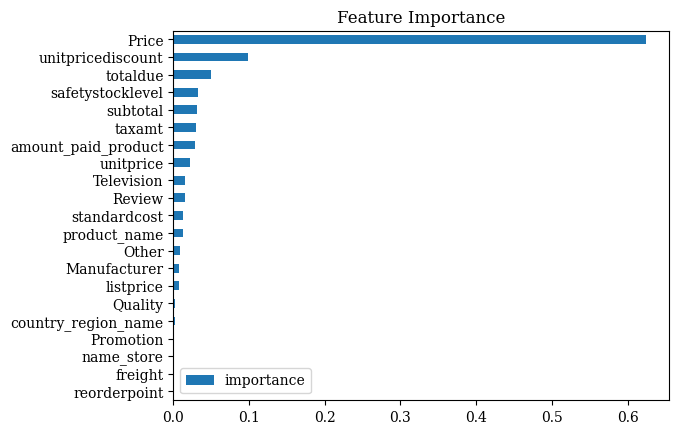

In [56]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Métricas

**Métricas MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio) - AutoArima**

In [57]:
test['prediction'] = reg.predict(X_test)
test['prediction'].reset_index()

,month,prediction
0,2014-04-01,28.202183
1,2014-04-01,35.846493
2,2014-04-01,22.823217
3,2014-04-01,67.359955
4,2014-04-01,16.146729
...,...,...
1585,2014-06-01,1.397167
1586,2014-06-01,2.297988
1587,2014-06-01,7.428416
1588,2014-06-01,1.378446


In [58]:
df1 = hts2.copy()
df1['prediction'] = pd.Series([float('NaN')] * len(df1), index=df1.index)

In [59]:
df1.iloc[-1590:, df1.columns.get_loc('prediction')] = test['prediction'].values
df1

,product_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,prediction
month,,,,,,,,,,,,,,,,,,,,,
2011-05-01,0,2,95,32726.4786,3153.7696,985.5530,36865.8012,5.1865,0.0,20.7460,...,3,0,0,0,0,0,0,0,4,NaN
2011-05-01,0,2,114,35944.1562,3461.7654,1081.8017,40487.7233,5.1865,0.0,20.7460,...,3,0,0,0,0,0,0,0,4,NaN
2011-05-01,0,3,2,11397.4992,1093.6394,341.7623,12832.9009,5.1865,0.0,15.5595,...,3,0,0,0,0,0,0,0,3,NaN
2011-05-01,0,3,3,20565.6206,1971.5149,616.0984,23153.2339,5.1865,0.0,10.3730,...,3,0,0,0,0,0,0,0,2,NaN
2011-05-01,0,3,6,38510.8973,3696.3979,1155.1244,43362.4196,5.1865,0.0,31.1190,...,3,0,0,0,0,0,0,0,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,151,1,19,69.9900,5.5992,1.7498,77.3390,69.9900,0.0,69.9900,...,3,0,0,0,0,1,0,0,1,1.397167
2014-06-01,151,2,19,148.9700,11.9176,3.7243,164.6119,139.9800,0.0,139.9800,...,6,1,0,0,0,1,0,0,2,2.297988
2014-06-01,151,3,19,978.3300,78.2664,24.4586,1081.0550,629.9100,0.0,629.9100,...,27,4,0,0,0,3,0,0,9,7.428416


In [60]:
def my_rmse(x,y):
    return np.round(np.sqrt(mse(x.values,y.values)), 2)

def my_mse(x, y):
    return np.round(mse(x.values, y.values), 2)

def my_mae(x, y):
    return np.round(np.nanmean(abs(x.values -  y.values)), 2)

In [61]:
k_rmse = my_rmse(test['orderqty'], test['prediction'])
k_mse = my_mse(test['orderqty'], test['prediction'])
k_mae = my_mae(test['orderqty'], test['prediction'])

results_xgboost = {'RMSE': [k_rmse], 'MSE': [k_mse], 'MAE': [k_mae]}
results_df_xgboost = pd.DataFrame(results_xgboost)
results_df_xgboost

,RMSE,MSE,MAE
0,1.41,1.98,0.76


In [62]:
df_resultado_metricas = pd.concat([results_df_arima, results_df_xgboost], ignore_index=True)
df_resultado_metricas = df_resultado_metricas.rename(index={0: 'AutoARIMA', 1: 'XGBoost'})

df_resultado_metricas.head()

,RMSE,MSE,MAE
AutoARIMA,148.43,22030.77,16.06
XGBoost,1.41,1.98,0.76


**Previsão sobre a demanda dos próximos 3 meses de cada produto/país/loja**

In [63]:
df_concat['produto/pais/loja'] = df_valores_concatenados['concat']

In [64]:
df_concat

,product_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,produto/pais/loja
month,,,,,,,,,,,,,,,,,,,,,
2011-05-01,0,2,95,32726.4786,3153.7696,985.5530,36865.8012,5.1865,0.0,20.7460,...,3,0,0,0,0,0,0,0,4,AWC Logo Cap/Canada/Original Bicycle Supply Co...
2011-05-01,0,2,114,35944.1562,3461.7654,1081.8017,40487.7233,5.1865,0.0,20.7460,...,3,0,0,0,0,0,0,0,4,AWC Logo Cap/Canada/Retail Mall
2011-05-01,0,3,2,11397.4992,1093.6394,341.7623,12832.9009,5.1865,0.0,15.5595,...,3,0,0,0,0,0,0,0,3,AWC Logo Cap/Estados Unidos/Area Bike Accessories
2011-05-01,0,3,3,20565.6206,1971.5149,616.0984,23153.2339,5.1865,0.0,10.3730,...,3,0,0,0,0,0,0,0,2,AWC Logo Cap/Estados Unidos/Better Bike Shop
2011-05-01,0,3,6,38510.8973,3696.3979,1155.1244,43362.4196,5.1865,0.0,31.1190,...,3,0,0,0,0,0,0,0,6,AWC Logo Cap/Estados Unidos/Bike Dealers Assoc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,151,1,19,69.9900,5.5992,1.7498,77.3390,69.9900,0.0,69.9900,...,3,0,0,0,0,1,0,0,1,"Women's Mountain Shorts, S/Australia/Cliente i..."
2014-06-01,151,2,19,148.9700,11.9176,3.7243,164.6119,139.9800,0.0,139.9800,...,6,1,0,0,0,1,0,0,2,"Women's Mountain Shorts, S/Canada/Cliente indi..."
2014-06-01,151,3,19,978.3300,78.2664,24.4586,1081.0550,629.9100,0.0,629.9100,...,27,4,0,0,0,3,0,0,9,"Women's Mountain Shorts, S/Estados Unidos/Clie..."


In [65]:
df_concat['prediction'] = pd.Series([float('NaN')] * len(df_concat), index=df_concat.index)

df_concat.iloc[-1590:, df_concat.columns.get_loc('prediction')] = test['prediction'].values
df_concat

,product_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,produto/pais/loja,prediction
month,,,,,,,,,,,,,,,,,,,,,
2011-05-01,0,2,95,32726.4786,3153.7696,985.5530,36865.8012,5.1865,0.0,20.7460,...,0,0,0,0,0,0,0,4,AWC Logo Cap/Canada/Original Bicycle Supply Co...,NaN
2011-05-01,0,2,114,35944.1562,3461.7654,1081.8017,40487.7233,5.1865,0.0,20.7460,...,0,0,0,0,0,0,0,4,AWC Logo Cap/Canada/Retail Mall,NaN
2011-05-01,0,3,2,11397.4992,1093.6394,341.7623,12832.9009,5.1865,0.0,15.5595,...,0,0,0,0,0,0,0,3,AWC Logo Cap/Estados Unidos/Area Bike Accessories,NaN
2011-05-01,0,3,3,20565.6206,1971.5149,616.0984,23153.2339,5.1865,0.0,10.3730,...,0,0,0,0,0,0,0,2,AWC Logo Cap/Estados Unidos/Better Bike Shop,NaN
2011-05-01,0,3,6,38510.8973,3696.3979,1155.1244,43362.4196,5.1865,0.0,31.1190,...,0,0,0,0,0,0,0,6,AWC Logo Cap/Estados Unidos/Bike Dealers Assoc...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,151,1,19,69.9900,5.5992,1.7498,77.3390,69.9900,0.0,69.9900,...,0,0,0,0,1,0,0,1,"Women's Mountain Shorts, S/Australia/Cliente i...",1.397167
2014-06-01,151,2,19,148.9700,11.9176,3.7243,164.6119,139.9800,0.0,139.9800,...,1,0,0,0,1,0,0,2,"Women's Mountain Shorts, S/Canada/Cliente indi...",2.297988
2014-06-01,151,3,19,978.3300,78.2664,24.4586,1081.0550,629.9100,0.0,629.9100,...,4,0,0,0,3,0,0,9,"Women's Mountain Shorts, S/Estados Unidos/Clie...",7.428416


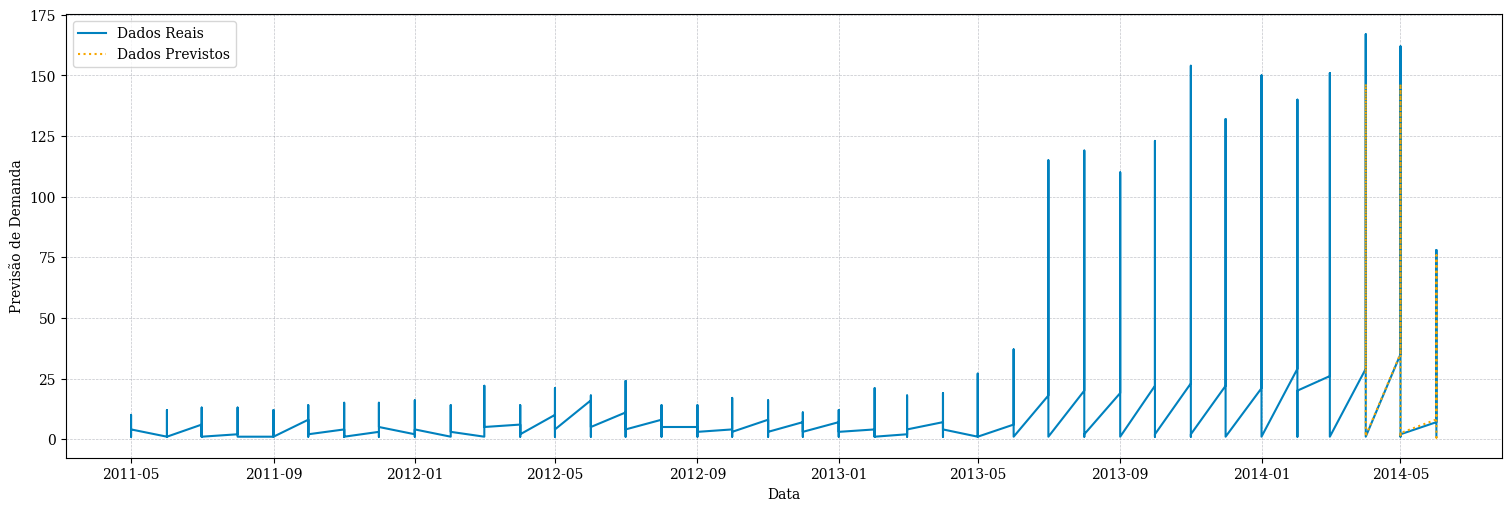

In [66]:
fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')

# Dados Reais
plt.plot(df_concat[['orderqty']], color=cerulean, label='Dados Reais')

# Dados Previstos
plt.plot(df_concat['prediction'], color=web_orange, linestyle='dotted', label='Dados Previstos')

date_to_plot = pd.to_datetime('2014-03-01')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Durante a análise das métricas de desempenho  entre os modelos AutoARIMA e XGBoost, pode-se observar diferenças significativas em suas performances. O modelo para o XGBoost apresentou resultados consideravelmente menores do que os do AutoARIMAm indicando uma melhor adaptação do modelo aos dados observados.</p>
</blockquote>

## Análise pelos Centros de Distribuição



<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>3.</b></font> Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?</h4>

  * Para determinar quais centros de distribuição tiveram o maior crescimento na demanda nos últimos três meses, foi calculado o crescimento absoluto da demanda para os Estados Unidos e para os países do resto do mundo.
  * Para isso, vamos utilizar os dados previstos utilizando o modelo ***XGBoost***.
  * Além disso, foram comparados os valores resultantes para identificar o grupo que registrou o maior aumento total na demanda.
</blockquote>


In [67]:
demanda_anterior = '2014-01-01'
demanda_prevista = '2014-06-30'

df_selected = df_concat.loc[demanda_anterior:demanda_prevista]
df_selected

,product_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,produto/pais/loja,prediction
month,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,19,26027.7700,2082.2216,650.6949,28760.6865,188.790,0.0,188.790,...,21,0,0,3,0,1,0,21,AWC Logo Cap/Alemanha/Cliente individual,NaN
2014-01-01,0,1,19,43196.4900,3455.7192,1079.9136,47732.1228,494.450,0.0,494.450,...,55,0,0,8,0,0,0,55,AWC Logo Cap/Australia/Cliente individual,NaN
2014-01-01,0,2,19,2473.4100,197.8728,61.8358,2733.1186,197.780,0.0,197.780,...,22,0,0,0,0,0,0,22,AWC Logo Cap/Canada/Cliente individual,NaN
2014-01-01,0,2,107,24795.1796,2356.5412,736.4191,27888.1399,5.394,0.0,21.576,...,0,0,0,0,0,0,0,4,AWC Logo Cap/Canada/Rapid Bikes,NaN
2014-01-01,0,2,150,45169.8960,4342.4608,1357.0190,50869.3758,5.394,0.0,26.970,...,0,0,0,0,0,0,0,5,AWC Logo Cap/Canada/Vigorous Exercise Company,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,151,1,19,69.9900,5.5992,1.7498,77.3390,69.990,0.0,69.990,...,0,0,0,0,1,0,0,1,"Women's Mountain Shorts, S/Australia/Cliente i...",1.397167
2014-06-01,151,2,19,148.9700,11.9176,3.7243,164.6119,139.980,0.0,139.980,...,1,0,0,0,1,0,0,2,"Women's Mountain Shorts, S/Canada/Cliente indi...",2.297988
2014-06-01,151,3,19,978.3300,78.2664,24.4586,1081.0550,629.910,0.0,629.910,...,4,0,0,0,3,0,0,9,"Women's Mountain Shorts, S/Estados Unidos/Clie...",7.428416


In [68]:
df_new = df_selected[['produto/pais/loja', 'orderqty', 'prediction']].copy()
df_new

,produto/pais/loja,orderqty,prediction
month,,,
2014-01-01,AWC Logo Cap/Alemanha/Cliente individual,21,NaN
2014-01-01,AWC Logo Cap/Australia/Cliente individual,55,NaN
2014-01-01,AWC Logo Cap/Canada/Cliente individual,22,NaN
2014-01-01,AWC Logo Cap/Canada/Rapid Bikes,4,NaN
2014-01-01,AWC Logo Cap/Canada/Vigorous Exercise Company,5,NaN
...,...,...,...
2014-06-01,"Women's Mountain Shorts, S/Australia/Cliente i...",1,1.397167
2014-06-01,"Women's Mountain Shorts, S/Canada/Cliente indi...",2,2.297988
2014-06-01,"Women's Mountain Shorts, S/Estados Unidos/Clie...",9,7.428416


**Selecionando os registros dos EUA e dos outros países**

In [69]:
df_usa = df_new[df_new['produto/pais/loja'].str.contains('Estados Unidos')]
df_outros_paises = df_new[~df_new['produto/pais/loja'].str.contains('Estados Unidos')]

In [70]:
def calcular_crescimento_demanda(df):
    df_anterior = df.loc['2014-01-01':'2014-03-01']
    demanda_anterior = df_anterior['orderqty'].sum()

    df_seguinte = df.loc['2014-04-01':'2014-06-01']
    previsao_seguinte = df_seguinte['prediction'].sum()

    crescimento_demanda = previsao_seguinte - demanda_anterior

    resultados = pd.DataFrame({
        'Demanda Anterior': [demanda_anterior],
        'Previsão de Demanda para Próximos 3 Meses': [round(previsao_seguinte)],
        'Crescimento de Demanda': [round(crescimento_demanda)]
    })

    return resultados

In [71]:
# Demanda para os centros de distribuição dos EUA
result_usa = calcular_crescimento_demanda(df_usa)
result_usa.head()

,Demanda Anterior,Previsão de Demanda para Próximos 3 Meses,Crescimento de Demanda
0,7785,5610,-2175


In [72]:
# Demanda para os centros de distribuição de outros países
result_outros_paises = calcular_crescimento_demanda(df_outros_paises)
result_outros_paises.head()

,Demanda Anterior,Previsão de Demanda para Próximos 3 Meses,Crescimento de Demanda
0,10837,8602,-2235


In [73]:
df_resultado_centros = pd.concat([result_usa, result_outros_paises], ignore_index=True)
df_resultado_centros = df_resultado_centros.rename(index={0: 'EUA', 1: 'Outros Países'})

df_resultado_centros.head()

,Demanda Anterior,Previsão de Demanda para Próximos 3 Meses,Crescimento de Demanda
EUA,7785,5610,-2175
Outros Países,10837,8602,-2235


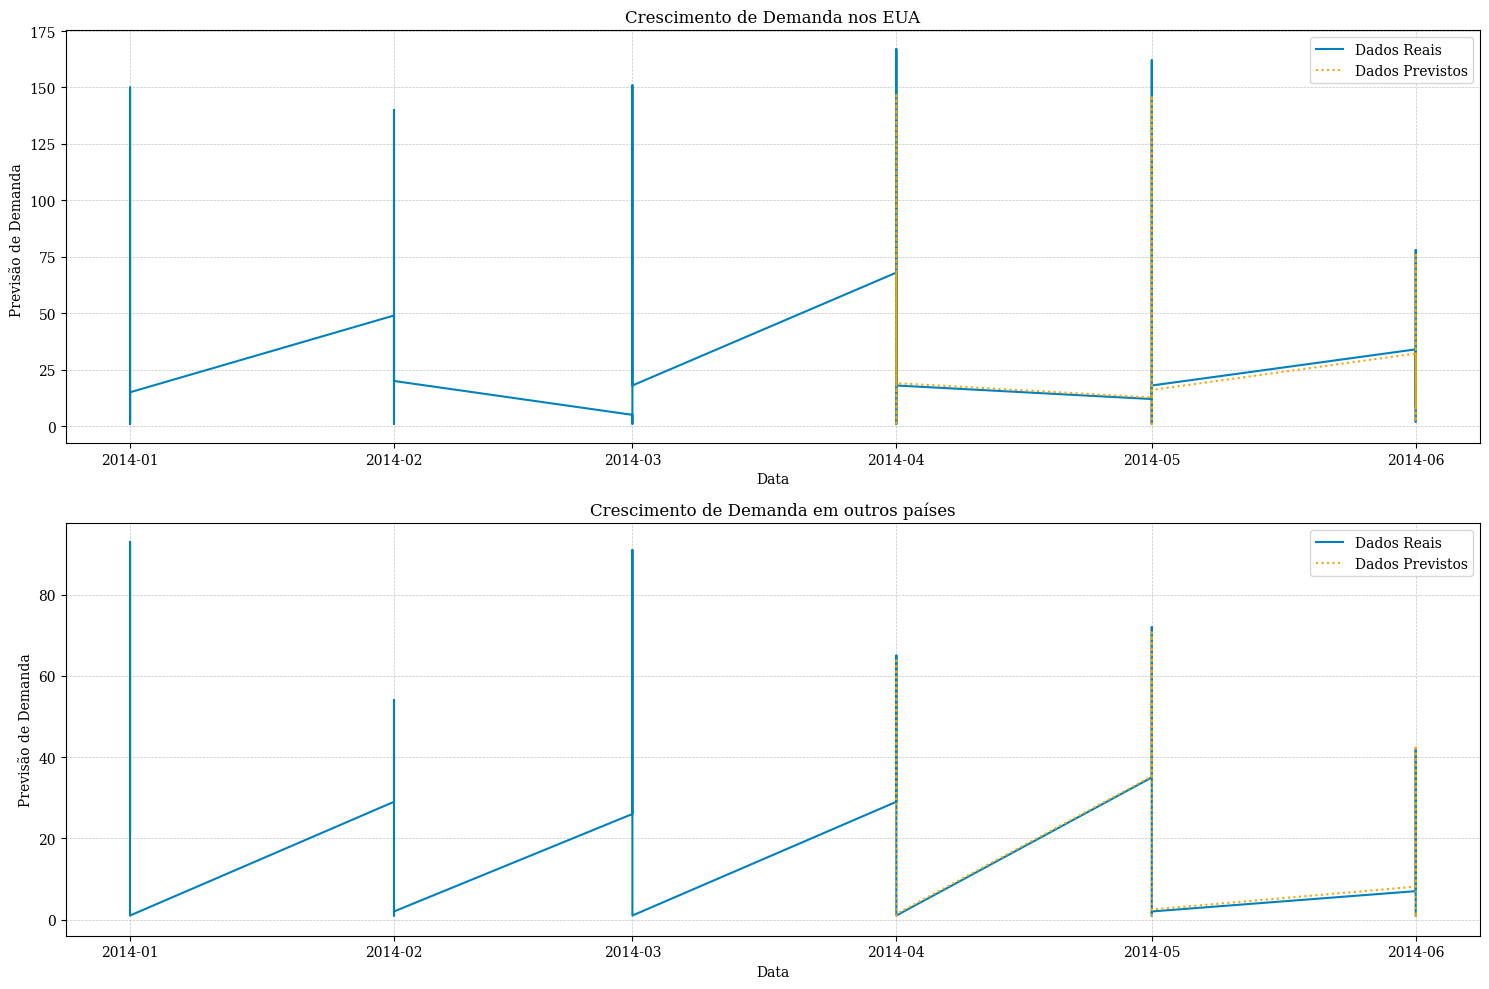

In [74]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(df_usa['orderqty'], color=cerulean, label='Dados Reais')
axes[0].plot(df_usa['prediction'], color=web_orange, linestyle='dotted', label='Dados Previstos')
axes[0].set_title('Crescimento de Demanda nos EUA')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Previsão de Demanda ')
axes[0].legend()
axes[0].grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

axes[1].plot(df_outros_paises['orderqty'], color=cerulean, label='Dados Reais')
axes[1].plot(df_outros_paises['prediction'], color=web_orange, linestyle='dotted', label='Dados Previstos')
axes[1].set_title('Crescimento de Demanda em outros países')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Previsão de Demanda')
axes[1].legend()
axes[1].grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.tight_layout()
plt.show()

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Portanto, observa-se uma queda na previsão de demanda para os próximos 3 meses. Além disso, os centros de distribuição nos EUA demonstram uma demanda ligeiramente inferior em comparação com os novos centros de distribuição estabelecidos em outros países.</p>
</blockquote>

## Análise previsão de demanda de luvas

<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>4.</b></font> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?</h4>
</blockquote>

In [75]:
data_inicial = '2014-04-01'
data_final = '2014-06-30'

df_selected = df_concat.loc[data_inicial:data_final]

df_new = df_selected[['produto/pais/loja', 'orderqty', 'prediction']].copy()
df_luvas = df_new[df_new['produto/pais/loja'].str.contains('Gloves')]
df_luvas

,produto/pais/loja,orderqty,prediction
month,,,
2014-04-01,"Half Finger Gloves, L/Alemanha/Cliente individual",5,5.086828
2014-04-01,"Half Finger Gloves, L/Australia/Cliente indivi...",7,7.137264
2014-04-01,"Half Finger Gloves, L/Canada/Cliente individual",6,6.074024
2014-04-01,"Half Finger Gloves, L/Estados Unidos/Cliente i...",22,22.171677
2014-04-01,"Half Finger Gloves, L/Franca/Cliente individual",5,5.076288
...,...,...,...
2014-06-01,"Half Finger Gloves, S/Australia/Cliente indivi...",2,1.694075
2014-06-01,"Half Finger Gloves, S/Canada/Cliente individual",6,6.079782
2014-06-01,"Half Finger Gloves, S/Estados Unidos/Cliente i...",9,9.627596


In [76]:
estimativa_demanda_luvas = df_luvas['prediction'].sum()
pares = estimativa_demanda_luvas / 2
estimativa_demanda_ziperes = estimativa_demanda_luvas

print(f'O fornecedor tem uma estimativa de {round(estimativa_demanda_ziperes)} zíperes necessários para {round(pares)} pares para os próximos 3 meses.')

O fornecedor tem uma estimativa de 433 zíperes necessários para 216 pares para os próximos 3 meses.


<blockquote class="callout callout_default" theme="✅">
  <p>✅ Portanto, o novo fornecedor de luvas precisa pedir 433 zíperes para os próximos 3 meses.</p>
</blockquote>